# Example application of the extended Kalman filter to the noisy pendulum

See examples 3.7 and 5.1 in Bayesian Filtering


This notebook demonstrates the application of the extended Kalman filter to the noisy pendulum.

It is based on examples 3.7 and 5.1 in "Bayesian Filtering and smoothing"


---

# 1. Specification of the system 

The second order ODE for a simple pendulum with unit mass and length is
$$\frac{d^2 \alpha}{dt^2} = -g \sin(\alpha) + w(t)$$

where $\alpha$ is the angle and $w(t)$ a random noise process. 


We can recast this as a pair of first order ODEs

$$\frac{dx_1}{dt} = x_2 $$
$$\frac{dx_2}{dt} = -g \sin(x_1) + w(t) $$

where $x_1 = \alpha$ and $x_2 = d \alpha/dt$

Lets assume that we only measure the horizontal position of the pendulum such that 

$$y = \sin(\alpha) + \text{noise}$$


# 2. Creating synthetic data <a name="synthetic"></a>



In [107]:
import numpy as np 
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

class NoisyPendulum:
    """ Simulates the signal from a noisy pendulum with process noise. 
    
    The observation is an arbitrary, non-linear combination of the states
    """
    
    def __init__(self,g,σp,σm, x, y,seed):
    
        self.g  = g
        self.σp = σp 
        self.σm = σm
        self.x  = x
        self.y  = y
        self.generator = np.random.default_rng(seed)



        
    def take_a_timestep(self):
        """ Call once for each new measurement at dt time from last call.
            Uses a basic Euler method.
        """
        

        #Discretised Q-matrix\
        Q11 = self.σp*self.dt**3 / 3
        Q12 = self.σp*self.dt**2 / 2
        Q21 = self.σp*self.dt**2 / 2
        Q22 = self.σp*self.dt
        Q = np.array([[Q11,Q12],[Q21,Q22]])
        Qnoise = self.generator.multivariate_normal(np.zeros(2),Q)

 
        #Derivatives
        dx = self.y
        dy = -self.g*np.sin(self.x)
        
        
        #Euler timestep
        self.x = self.x  + self.dt*dx + Qnoise[0]
        self.y = self.y  + self.dt*dy + Qnoise[1]

     


        #The observation, no noise
        observation_no_noise = np.sin(self.x)

        #add noise to the observation
        observation = observation_no_noise + self.generator.normal(0, self.σm) 

        return self.x,self.y,observation_no_noise,observation



    def integrate(self,dt,n_steps):
        """ Integrate for n_steps timesteps and return an array that holds the states and observations
        """

        self.dt = dt
        self.n_steps      = n_steps
        self.t            = np.arange(0,self.n_steps*self.dt,self.dt)
        self.results      = np.zeros((self.n_steps,4)) # 4 columns: x,y,observation_no_noise,observation 

        for i in range(self.n_steps):
            self.results[i,:] = self.take_a_timestep()



    def plot_phase_space(self):
        """
        A plotting function which plots the evolution in the x-y phase plane
        """


        #Setup the figure
        h,w = 6,6
        rows = 1
        cols = 1
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)
    
        x = self.results[:,0]
        y = self.results[:,1]
        ax.plot(x,y)
        

        #Clean up axes
        fs=20
        ax.set_xlabel(r'$x_1$', fontsize=fs)
        ax.set_ylabel(r'$x_2$', fontsize=fs)
        ax.xaxis.set_tick_params(labelsize=fs-4)
        ax.yaxis.set_tick_params(labelsize=fs-4)


    def plot_timeseries(self,plot_true_state = False, prediction_data=None):
        """
        A plotting function which plots the states/observations as a function of time
        """


        #Setup the figure
        h,w =8,8
        rows = 3
        cols = 1
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)

    
        data_label = 'data'
        
        axes[0].plot(self.t,self.results[:,0],label=data_label) #x1
        axes[1].plot(self.t,self.results[:,1],label=data_label) #x2

        if plot_true_state:
            axes[2].scatter(self.t,self.results[:,3],label=data_label,marker='x') #actual noisy observations
            axes[2].plot(self.t,self.results[:,2],label='Truth',c='C1') #observation, no noise
        else:
            axes[2].plot(self.t,self.results[:,3],label=data_label) #actual noisy observations



        if prediction_data is not None:
            states = prediction_data[0]
            measurements = prediction_data[1]

            
            prediction_color = 'C2'
            prediction_label = 'prediction'
            axes[0].plot(self.t,states[:,0],c=prediction_color,label=prediction_label)
            axes[1].plot(self.t,states[:,1],c=prediction_color,label=prediction_label)
            
            axes[2].plot(self.t,measurements[:,0],c=prediction_color,label=prediction_label)

            plt.legend(fontsize=12)

        
    
        #Clean up axes
        fs=20
        axes[2].set_xlabel('t', fontsize=fs)

        axes[0].set_ylabel('x', fontsize=fs)
        axes[1].set_ylabel('y', fontsize=fs)
        axes[2].set_ylabel('z', fontsize=fs)

        plt.subplots_adjust(hspace=0.0)

        for ax in axes:
            ax.xaxis.set_tick_params(labelsize=fs-4)
            ax.yaxis.set_tick_params(labelsize=fs-4)

        # ax.legend(prop={'size':fs})



Lets take a quick look at the data

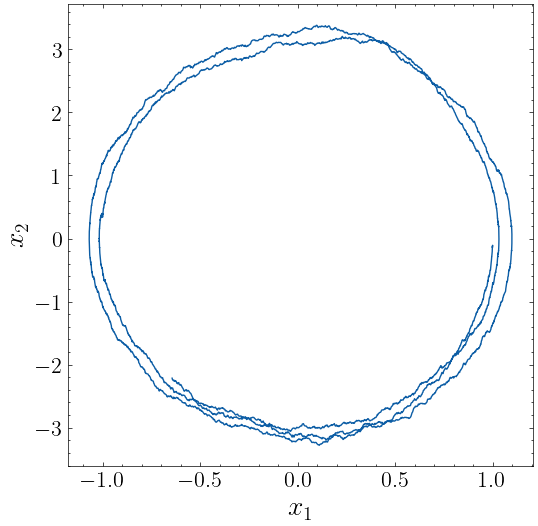

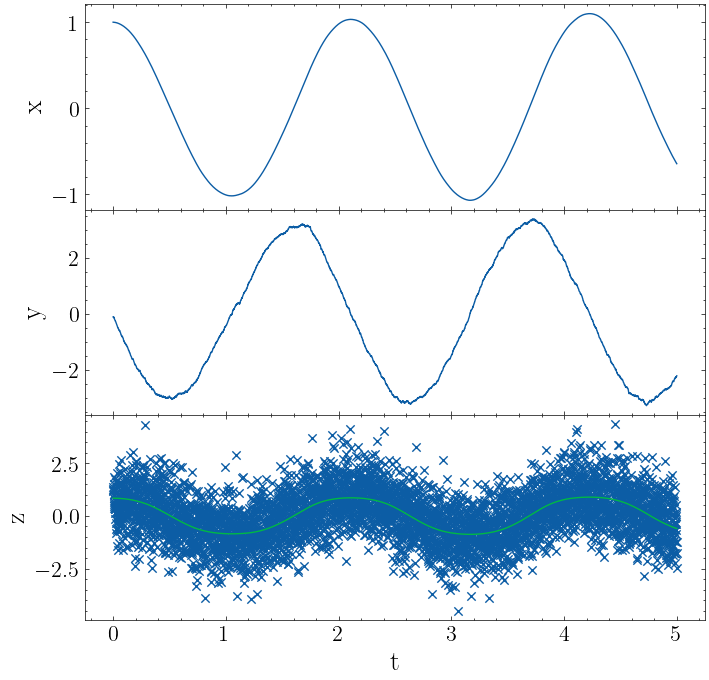

In [108]:
#Parameters of the system
g    = 10.0
σp   = 0.1
σm   = 1.0
x0   = 1.0
y0   = -0.1
seed = 1

#Initialise the class
Pendulum = NoisyPendulum(g,σp,σm, x0, y0,seed)

#Integrate
Pendulum.integrate(dt=0.001,n_steps=5000)

#Plot
Pendulum.plot_phase_space()
Pendulum.plot_timeseries(plot_true_state=True)

## 2. Mathematics of the Extended Kalman filter

For this notebok

A reccomended resource for extended Kalman filtering is Chapter 7 of ["Fundamentals of Kalman Filtering: A Practical Approach"](https://arc.aiaa.org/doi/book/10.2514/4.102776)


In summary 

* $\mathbf{\dot{x}} = f(\mathbf{x}) + \mathbf{w}$ 

* $\mathbf{z} = h(\mathbf{x}) + \mathbf{v} $

* $\mathbf{w} \sim \mathcal{N}(0,\mathbf{\Sigma}_p)$, $\mathbf{v} \sim \mathcal{N}(0,\mathbf{\Sigma}_m)$

* $\mathbf{F} = \frac{\partial f(\mathbf{x})}{\partial \mathbf{x}}$
* $\mathbf{H} = \frac{\partial h(\mathbf{x})}{\partial \mathbf{x}}$
* $\mathbf{Q} = E(\mathbf{w} \mathbf{w}^{T})$

### 2.1 Mathematics of the Van der Pol EKF


In order to deploy the the extended Kalman filter we need to specify all the Kalman "machinery", i.e. the various model-specific functions and matrices.

The machinery for the VDP model is as follows:


* States $\mathbf{x} = (x,y)$
* State transition function $f(\mathbf{x}) =\begin{bmatrix}
           y \\
           \mu(1-x^2)y - x\\
         \end{bmatrix}$ 

* Observation function $h(\mathbf{x}) = xy$

* State Jacobian $F = \frac{\partial f}{\partial \mathbf{x}} =\begin{pmatrix}
           0 & 1 \\
           -2\mu x y -1 & \mu (1-x^2)\\
         \end{pmatrix}$

* Measurement Jacobian $H = \frac{\partial h}{\partial \mathbf{x}} = \begin{pmatrix}
           y  \\
           x\\
         \end{pmatrix}$

* Fundamental matrix $\mathbf{\Phi}(t) = \mathbf{I} + \mathbf{F} t$

* Discretised Q-matrix $\mathbf{Q} = \int_0^{T_s} \mathbf{\Phi}(t) \mathbf{Q} \mathbf{\Phi}^T(t) dt = \sigma_p^2 T_s\begin{pmatrix} 1 & T_s F_{21}/2 \\ T_s F_{21}/2  & T_s^2 F_{21}^2 / 3  \end{pmatrix}$ 
  * where $F_{21} = -2\mu x y -1$


* R-matrix $\mathbf{R} = \sigma_{\rm m}^2$


The above is implemented in `model.py`(todo implement this as a meta-class, allow used defined models)



## 3. Running the EKF 


We are now in a position to run the EKF on our synthetic data

#### 3.1 Setup 

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import sys
sys.path.append("../src") # add src to path so it can be accessed here 

#### 3.2 Generate data 

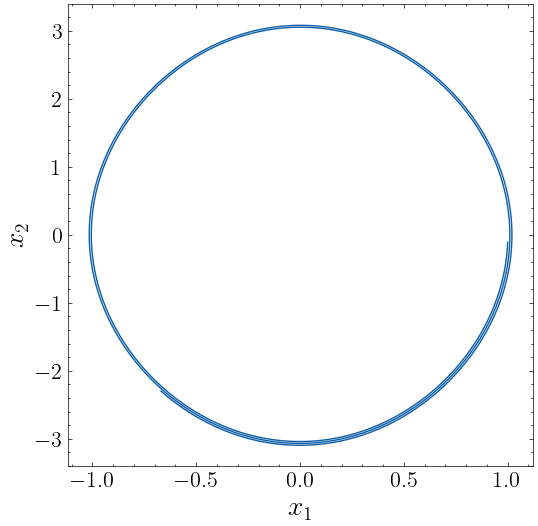

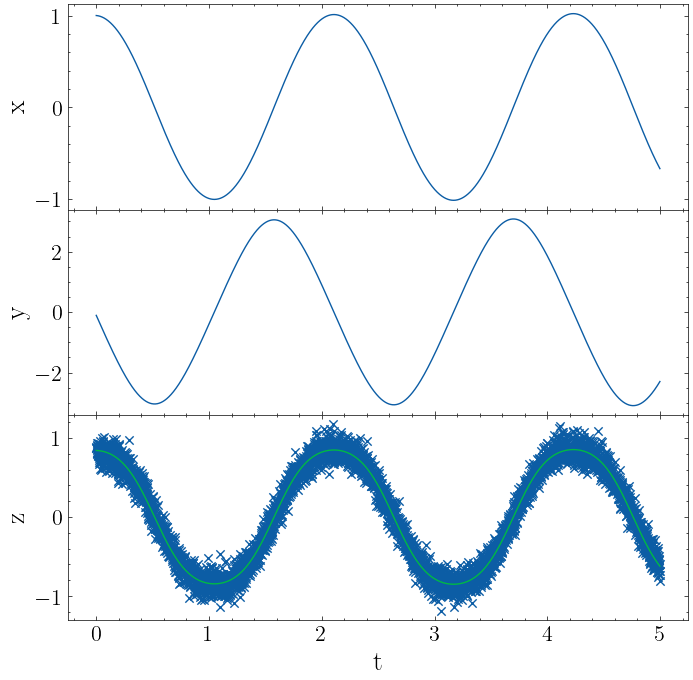

In [140]:
#Parameters of the system
g    = 10.0
σp   = 0.0
σm   = 0.1
x0   = 1.0
y0   = -0.1
seed = 1
dt   = 0.001

#Initialise the class
Pendulum = NoisyPendulum(g,σp,σm, x0, y0,seed)

#Integrate
Pendulum.integrate(dt=dt,n_steps=5000)

#Plot
Pendulum.plot_phase_space()
Pendulum.plot_timeseries(plot_true_state=True)

#### 3.3 Run the filter 

In [141]:
from model import KalmanPendulum
from kalman_filter import ExtendedKalmanFilter
from priors import bilby_priors_dict


{'g': 10.0, 'σp': 0.0, 'σm': 0.1}
0 [ 0.9999     -0.10841471] [0.87446066]
innovation: [0.0331023]
1 [ 1.06082905 -0.11099514] [0.88599582]
innovation: [0.01328952]
2 [ 1.0729293  -0.11507453] [0.87775245]
innovation: [-0.00079576]
3 [ 1.07231333 -0.12431165] [0.8958988]
innovation: [0.0176494]
4 [ 1.08075254 -0.11903193] [0.7929433]
innovation: [-0.08931292]
5 [ 1.04568329 -0.21874118] [0.81183272]
innovation: [-0.05332489]
6 [ 1.0269818  -0.29686724] [0.8418112]
innovation: [-0.01377642]
7 [ 1.02249495 -0.32693115] [0.94158344]
innovation: [0.08834275]
8 [ 1.04574726 -0.1770399 ] [0.82334325]
innovation: [-0.04186734]
9 [ 1.03592201 -0.26765331] [0.86245752]
innovation: [0.00226129]
10 [ 1.03613583 -0.27124454] [0.80286512]
innovation: [-0.05743831]
11 [ 1.02460605 -0.4198623 ] [0.90682767]
innovation: [0.05253622]
12 [ 1.03393322 -0.28674147] [0.85715893]
innovation: [-0.00201163]
13 [ 1.03330076 -0.30109843] [0.77197632]
innovation: [-0.08686309]
14 [ 1.01881031 -0.57643284] [0.830

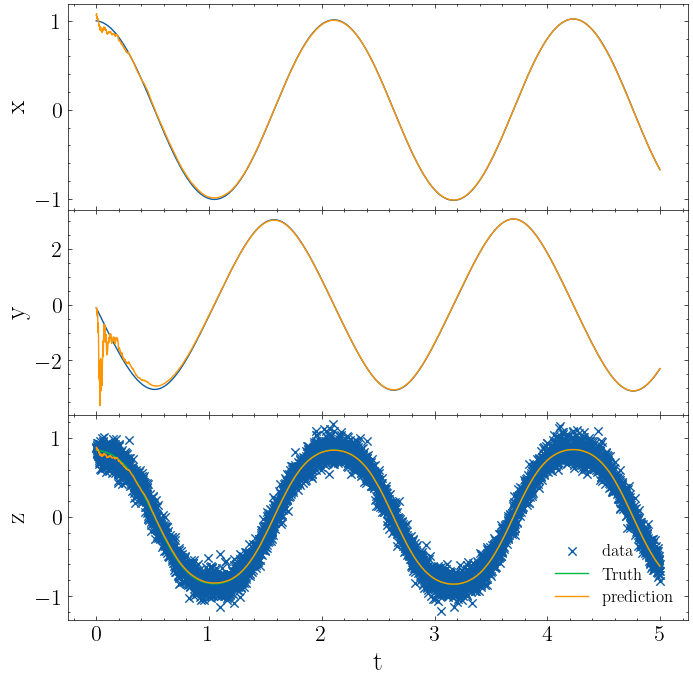

In [169]:
#Define the model
model = KalmanPendulum(dt=dt)

#Setup the filter
x_guess = np.array(([Pendulum.results[0,0],Pendulum.results[0,1]])) #guess of the initial states. set equal to true values for now. Obv we don't know this in practice/ todo


data = Pendulum.results[:,3] # these are the actual observations 

#data = Pendulum.results[:,2] # these are the actual observations 


P0 = 10*np.array(([1.0,0.1],[0.1,1.0]))

KF = ExtendedKalmanFilter(model,data.reshape(len(data),1),x_guess,P0)

#Set the system parameters :: we use bilby keeping an eye on when we will be using this in conjunction with e.g. nested sampling
init_parameters,parameters_dict = bilby_priors_dict(g,σp,σm)
parameters = parameters_dict.sample()
parameters['σp'] = parameters['σp']
print(parameters)

#Run the filter
KF.run(parameters)

#Plot the results 
Pendulum.plot_timeseries(plot_true_state=True, prediction_data=[KF.state_predictions,KF.measurement_predictions])

# Appendix / scratch space

In [136]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])

In [137]:
np.dot(a,b)

array([[19, 22],
       [43, 50]])

In [138]:
a@b 

array([[19, 22],
       [43, 50]])

In [124]:

x1 = Pendulum.results[:,0]
x2 = Pendulum.results[:,1]
data = Pendulum.results[:,2] 

In [138]:
x1[1]

0.9997915852901519

In [143]:
x2[1]

-0.11682887935177941

In [122]:
data 

array([ 0.84141695,  0.84135836,  0.84129521, ..., -0.61732181,
       -0.619138  , -0.62094605])

In [129]:
np.sin(x1) 

array([ 0.84141695,  0.84135836,  0.84129521, ..., -0.61732181,
       -0.619138  , -0.62094605])

In [155]:
#Parameters of the system
g    = 10.0
σp   = 0.0
σm   = 0.1
x0   = 1.0
y0   = -0.1
seed = 1
dt   = 0.001


#Derivatives
dx = x2[0]
dy = -g*np.sin(x1[0])


#Euler timestep
x = x1[0]  + dt*dx #+ Qnoise[0]
y = x2[0]  + dt*dy #+ Qnoise[1]


In [156]:
x 

0.9997915852901519

In [157]:
y 

-0.11682887935177941

In [163]:
print(x2[0],dt,dy) #+ Qnoise[1]

-0.10841470984807897 0.001 -8.414169503700448
